# Analysis of the Area of the bounding boxes
## Bounding boxes too small or too large can't be an helipad

In [10]:
import os
import json
from math import radians, sin, atan, cos, atan2, sqrt
import matplotlib.pyplot as plt

In [2]:
index_path = "../helipad_path_over_0_m10.txt"
meta_folder = "C:\\Users\\AISG\\Documents\\Jonas\\Real_World_Dataset_TMS_meta\\sat\\"
bounding_boxes_groundtruth_path = "C:\\Users\\AISG\\Documents\\Jonas\\Helipad\\Real_World_Detected_Boxes\\model_10_0.0_groundtruth\\"
model_number = 10

In [6]:
def filter_by_area(bb_image_path, meta_folder, model_number, lower=200, higher=600):
    bb_image_name = os.path.splitext(os.path.basename(bb_image_path))[0]
    image_info = bb_image_name.split('_')
    zoom = image_info[1]
    xtile = image_info[2]
    ytile = image_info[3]
    
    meta_path = os.path.join(meta_folder, zoom, xtile, f"Satellite_{zoom}_{xtile}_{ytile}.meta")
    
    if not os.path.isfile(meta_path):
        print("Meta File does not exist")
        return -1
    
    with open(meta_path, 'r') as j:
        meta = json.load(j)
    j.close()
    bounds = meta["predicted"]["model_{}".format(model_number)]["coordinates"]["bounds"]
    l = compute_distance_between_two_gps_points(bounds[0][0], bounds[0][1])
    L = compute_distance_between_two_gps_points(bounds[0][0], bounds[0][2])
    area = l*L

    if area<lower or area>higher:
        return 0
    else:
        return 1

def compute_distance_between_two_gps_points(point_1, point_2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(point_1[0])
    lon1 = radians(point_1[1])
    lat2 = radians(point_2[0])
    lon2 = radians(point_2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 1000
    
    return distance

def find_groundtruth_from_name(meta_filename, bb_groundtruth_path):
    helipad_filenames = os.listdir(os.path.join(bb_groundtruth_path, 'helipad'))
    fp_filenames = os.listdir(os.path.join(bb_groundtruth_path, 'false_positive'))
    meta_info = meta_filename.split('.')[0]
    for filename in helipad_filenames:
        image_name = "_".join(filename.split('_')[:4])
        if image_name == meta_info:
            return 'helipad'
    
    for filename in fp_filenames:
        image_name = "_".join(filename.split('_')[:4])
        if image_name == meta_info:
            return 'false_positive'

In [7]:
def benchmark_area_filter(bb_groundtruth_path, meta_folder, model_number=10, lower=200, higher=600):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for subdir, dirs, files in os.walk(os.path.join(bb_groundtruth_path, 'helipad'), topdown=True):
        for file in files:
            image_path = os.path.join(subdir, file)
            res = filter_by_area(image_path, meta_folder, model_number, lower=lower, higher=higher)
            if res == 1:
                TP += 1
            elif res == 0:
                FN += 1
    
    for subdir, dirs, files in os.walk(os.path.join(bb_groundtruth_path, 'false_positive'), topdown=True):
        for file in files:
            image_path = os.path.join(subdir, file)
            res = filter_by_area(image_path, meta_folder, model_number, lower=lower, higher=higher)
            if res == 1:
                FP += 1
            elif res == 0:
                TN += 1
        
    return {'TP': TP, 
            'TN': TN,
            'FP': FP,
            'FN': FN}

In [74]:
res = benchmark_area_filter(bounding_boxes_groundtruth_path, meta_folder, model_number=10, lower=200, higher=600)

In [75]:
res

{'TP': 55, 'TN': 189, 'FP': 311, 'FN': 11}

In [29]:
helipad_area = []
fp_area = []
fp_scores = []
helipad_scores = []
helipad_scores_area = []
fp_scores_area = []

with open(index_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
#         print(line)
        groundtruth = find_groundtruth_from_name(line, bounding_boxes_groundtruth_path)
#         print(groundtruth)
        if groundtruth == None:
            continue
        info = line.split('_')
        zoom = info[1]
        xtile = info[2]
        ytile = info[3]
        if line[len(line)-1] == '\n':
            line = line[:len(line)-1]
        meta_path = os.path.join(meta_folder, zoom, xtile, line)
        with open(meta_path, 'r') as j:
            meta = json.load(j)
        j.close()
        bounds = meta["predicted"]["model_{}".format(model_number)]["coordinates"]["bounds"]
        scores = meta["predicted"]["model_{}".format(model_number)]["score"]
        l = compute_distance_between_two_gps_points(bounds[0][0], bounds[0][1])
        L = compute_distance_between_two_gps_points(bounds[0][0], bounds[0][2])
        area = l*L
        if groundtruth == 'helipad':
            helipad_area.append(area)
            helipad_scores.extend(scores)
            if area >= 164 and area < 547:
                helipad_scores_area.extend(scores)
        elif groundtruth == 'false_positive':
            fp_area.append(area)
            fp_scores.extend(scores)
            if area >= 164 and area < 547:
                fp_scores_area.extend(scores)
#         print(distance)
#         print()

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         2.,  2.,  0.,  1.,  3.,  4., 10., 14., 19.]),
 array([0.70625412, 0.70915435, 0.71205458, 0.7149548 , 0.71785503,
        0.72075525, 0.72365548, 0.7265557 , 0.72945593, 0.73235615,
        0.73525638, 0.73815661, 0.74105683, 0.74395706, 0.74685728,
        0.74975751, 0.75265773, 0.75555796, 0.75845818, 0.76135841,
        0.76425864, 0.76715886, 0.77005909, 0.77295931, 0.77585954,
        0.77875976, 0.78165999, 0.78456021, 0.78746044, 0.79036066,
        0.79326089, 0.7961

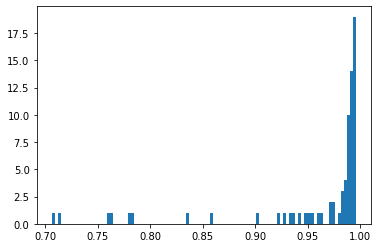

In [55]:
plt.hist(helipad_scores_area, bins=100)

(array([ 2.,  0.,  3.,  1.,  1.,  1.,  2.,  0.,  2.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  3.,  2.,  2.,  2.,  3.,  0.,  1.,  0.,  3.,
         1.,  2.,  4.,  2.,  2.,  2.,  3.,  2.,  1.,  0.,  2.,  2.,  3.,
         4.,  3.,  3.,  1.,  2.,  2.,  0.,  3.,  0.,  0.,  1.,  1.,  1.,
         3.,  4.,  1.,  1.,  0.,  3.,  2.,  2.,  1.,  1.,  1.,  1.,  3.,
         3.,  3.,  0.,  2.,  3.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,
         3.,  1.,  5.,  4.,  4.,  3.,  8.,  2.,  4.,  4.,  6.,  7.,  9.,
         5.,  7.,  9.,  4., 10., 10., 23., 23., 30.]),
 array([0.70513272, 0.70802849, 0.71092426, 0.71382003, 0.71671579,
        0.71961156, 0.72250733, 0.7254031 , 0.72829886, 0.73119463,
        0.7340904 , 0.73698617, 0.73988194, 0.7427777 , 0.74567347,
        0.74856924, 0.75146501, 0.75436077, 0.75725654, 0.76015231,
        0.76304808, 0.76594384, 0.76883961, 0.77173538, 0.77463115,
        0.77752692, 0.78042268, 0.78331845, 0.78621422, 0.78910999,
        0.79200575, 0.7949

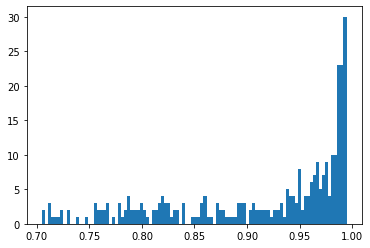

In [56]:
plt.hist(fp_scores_area, bins=100)

(array([ 2.,  0.,  1.,  1.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  3.,  1.,  3.,
         2.,  4.,  7., 49.]),
 array([0.70625412, 0.71592154, 0.72558896, 0.73525638, 0.7449238 ,
        0.75459122, 0.76425864, 0.77392605, 0.78359347, 0.79326089,
        0.80292831, 0.81259573, 0.82226315, 0.83193056, 0.84159798,
        0.8512654 , 0.86093282, 0.87060024, 0.88026766, 0.88993507,
        0.89960249, 0.90926991, 0.91893733, 0.92860475, 0.93827217,
        0.94793958, 0.957607  , 0.96727442, 0.97694184, 0.98660926,
        0.99627668]),
 <a list of 30 Patch objects>)

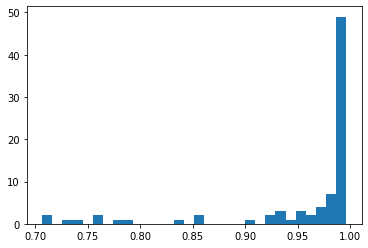

In [17]:
plt.hist(helipad_scores, bins=30)

(array([ 11.,   7.,   5.,   1.,   2.,  12.,   9.,   6.,  10.,  11.,   4.,
         15.,  10.,  10.,   3.,  10.,  16.,  11.,   8.,  14.,   8.,  12.,
         13.,  17.,  19.,  30.,  25.,  43.,  50., 129.]),
 array([0.70392275, 0.71361564, 0.72330853, 0.73300142, 0.74269431,
        0.75238721, 0.7620801 , 0.77177299, 0.78146588, 0.79115877,
        0.80085166, 0.81054455, 0.82023745, 0.82993034, 0.83962323,
        0.84931612, 0.85900901, 0.8687019 , 0.87839479, 0.88808769,
        0.89778058, 0.90747347, 0.91716636, 0.92685925, 0.93655214,
        0.94624503, 0.95593793, 0.96563082, 0.97532371, 0.9850166 ,
        0.99470949]),
 <a list of 30 Patch objects>)

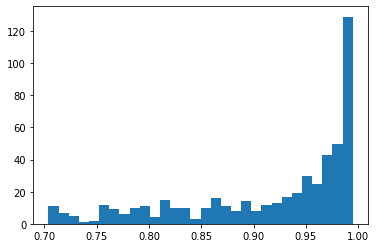

In [18]:
plt.hist(fp_scores, bins=30)

(array([ 1.,  5., 10.,  5.,  4., 10.,  6.,  3.,  4.,  6.,  4.,  2.,  1.,
         2.,  0.,  0.,  1.,  1.,  0.,  1.]),
 array([126.05546405, 164.30723451, 202.55900498, 240.81077545,
        279.06254591, 317.31431638, 355.56608685, 393.81785731,
        432.06962778, 470.32139825, 508.57316871, 546.82493918,
        585.07670965, 623.32848011, 661.58025058, 699.83202105,
        738.08379151, 776.33556198, 814.58733245, 852.83910292,
        891.09087338]),
 <a list of 20 Patch objects>)

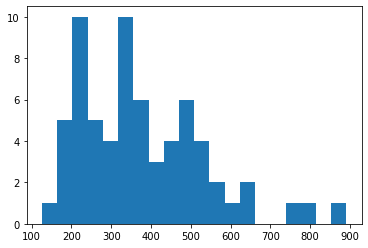

In [25]:
plt.hist(helipad_area, bins=20)

(array([ 5., 20., 70., 81., 70., 47., 51., 44., 28., 27., 16., 12., 11.,
         3.,  6.,  3.,  2.,  0.,  0.,  3.]),
 array([  54.21047238,  134.63690895,  215.06334552,  295.48978209,
         375.91621866,  456.34265523,  536.76909181,  617.19552838,
         697.62196495,  778.04840152,  858.47483809,  938.90127466,
        1019.32771123, 1099.7541478 , 1180.18058437, 1260.60702094,
        1341.03345751, 1421.45989408, 1501.88633065, 1582.31276722,
        1662.73920379]),
 <a list of 20 Patch objects>)

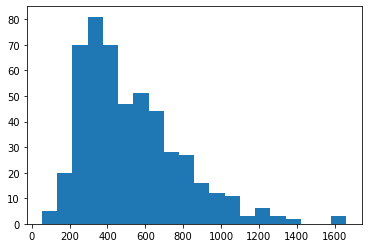

In [26]:
plt.hist(fp_area, bins=20)

(array([ 0.,  1.,  5., 10.,  8., 11.,  7.,  3.,  7.,  7.,  2.,  2.,  0.,
         1.,  0.,  1.,  1.,  0.,  0.]),
 array([   0,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
         600,  650,  700,  750,  800,  850,  900,  950, 1000]),
 <a list of 19 Patch objects>)

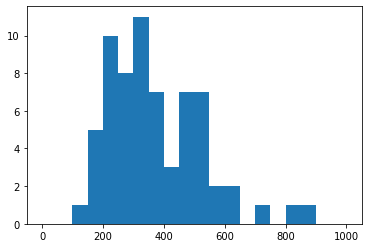

In [19]:
plt.hist(helipad_area, bins=[0, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])

(array([ 2.,  3., 16., 32., 47., 56., 43., 46., 22., 35., 29., 29., 30.,
        17., 13., 19., 16.,  7.,  6.]),
 array([   0,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
         600,  650,  700,  750,  800,  850,  900,  950, 1000]),
 <a list of 19 Patch objects>)

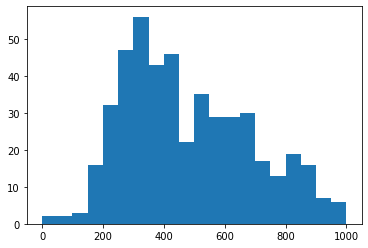

In [64]:
plt.hist(fp_area, bins=[0, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])